# nb-model_xg-model-pyro

In [1]:
import sys
import os
from os import sep
from os.path import dirname, realpath
from pathlib import Path
from collections import OrderedDict
from functools import partial, reduce
import logging

def get_cwd(fname, subdir, crunch_dir=realpath(Path.home()) +sep +'crunch' +sep):
    """
    Convenience function to make a directory string for the current file based on inputs.
    Jupyter Notebook in Anaconda invokes the Python interpreter in Anaconda's subdirectory
    which is why changing sys.argv[0] is necessary. In the future a better way to do this
    should be preferred..
    """
    return crunch_dir +subdir +fname

def fix_path(cwd):
    """
    Convenience function to fix argv and python path so that jupyter notebook can run the same as
    any script in crunch.
    """
    sys.argv[0] = cwd
    module_path = os.path.abspath(os.path.join('..'))
    if module_path not in sys.path:
        sys.path.append(module_path)

fname = 'nb-model_xg-model-pyro.ipynb'
dir_name = 'model'
fix_path(get_cwd(fname, dir_name +sep))

import numpy as np
import pandas as pd
#import matplotlib.pyplot as plt
from dask import delayed, compute
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.dataset import Dataset as TorchDataset
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import weight_norm
import torchfunc
from torchmeta.utils.data import BatchMetaDataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping

from ipywidgets import interact, interactive, fixed
from IPython.display import display

pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 50)

from common_util import MODEL_DIR, RECON_DIR, JSON_SFX_LEN, DT_CAL_DAILY_FREQ, pd_to_np, pairwise, df_midx_restack, compose, is_type, df_rows_in_year, list_all_eq, remove_dups_list, NestedDefaultDict, set_loglevel, search_df, chained_filter, get_variants, load_df, dump_df, load_json, gb_transpose, pd_common_index_rows, filter_cols_below, inner_join, outer_join, ser_shift, list_get_dict, window_iter, benchmark
from common_util import pd_rows_key_in, pd_split_ternary_to_binary, np_value_counts, isnt, window_iter, all_eq, np_assert_identical_len_dim, pd_idx_rename, midx_get_level, pd_rows, midx_intersect, pd_get_midx_level, pd_common_idx_rows, midx_split, pd_midx_to_arr, window_iter, np_at_least_nd, np_is_ndim, identity_fn
from model.common import DATASET_DIR, XG_PROCESS_DIR, XG_DATA_DIR, XG_DIR, PYTORCH_MODELS_DIR, TEST_RATIO, VAL_RATIO, EXPECTED_NUM_HOURS, default_dataset
from model.common import PYTORCH_ACT_MAPPING, PYTORCH_OPT_MAPPING, PYTORCH_SCH_MAPPING, PYTORCH_LOSS_MAPPING
from model.xg_util import xgload, get_xg_feature_dfs, get_xg_label_target_dfs
from model.preproc_util import temporal_preproc_3d, stride_preproc_3d
from model.train_util import pd_to_np_tvt, batchify
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)

CRITICAL:root:script location: /home/kev/crunch/model/nb-model_xg-model-pyro.ipynb
CRITICAL:root:using project dir: /home/kev/crunch/


Prune the xg data down to the data of interest to use in further experiments.

## Load Data

In [2]:
assets = ['sp_500', 'russell_2000', 'nasdaq_100', 'dow_jones']
chosen_asset = assets[0]

In [3]:
fd = get_xg_feature_dfs(chosen_asset)
ld, td = get_xg_label_target_dfs(chosen_asset)

In [4]:
d_all_common = ['dwrmx', 'dwrod', 'dwrpt', 'dwrzn', 'dffd']
d_extra = ['dlogret', 'dohlca', 'ddiff', 'dc', 'dwrxmx']

In [5]:
h_all_common = ['hdmx', 'hdod', 'hdpt', 'hdzn']
h_extra = ['hdgau', 'hduni', 'hohlca']

Test axefiles per asset and source (4 * 4 * 5 + 4 * 3 * 4 = ~128 tests) , what model to use?
* TCN
* XGBOOST
* RF

OR I just make a best guess on the best features. I record the tensor dimensions (allow easy modification) and get going on the meat of this stuff. I can start with only h/d pba, play with that until it's working well then iteratively add other sources.

I start with one asset, move to others after the first asset's model works.

I know roughly what features to use. I need to now determine the model design.

In [6]:
h_all_common, d_all_common

(['hdmx', 'hdod', 'hdpt', 'hdzn'],
 ['dwrmx', 'dwrod', 'dwrpt', 'dwrzn', 'dffd'])

## Select Data

### Choose Features and Join

In [7]:
for k0, v0 in fd.items():
    print(k0)
    for k1,v1 in fd[k0].items():
        print('\t' +k1)
        for k2, v2 in fd[k0][k1].items():
            print('\t\t' +k2)
            for k3, v3 in fd[k0][k1][k2].items():
                print('\t\t\t' +k3)

h
	pba
		hdgau
			pba_hlh_hlogret_hdzn_hdgau(8)_hret_hspread
			pba_hoc_hlogret_hdzn_hdgau(8)_hret_hspread
			pba_hohlca_hdzn_hdgau(8)
		hdmx
			pba_hlh_hlogret_hdmx_hret_hspread
			pba_hoc_hlogret_hdmx_hret_hspread
			pba_hohlca_hdmx
		hdod
			pba_hlh_hlogret_hdod_hret_hspread
			pba_hoc_hlogret_hdod_hret_hspread
			pba_hohlca_hdod
		hdpt
			pba_hlh_hlogret_hdpt_hret_hspread
			pba_hoc_hlogret_hdpt_hret_hspread
			pba_hohlca_hdpt
		hduni
			pba_hlh_hlogret_hdmx_hduni(8)_hret_hspread
			pba_hoc_hlogret_hdmx_hduni(8)_hret_hspread
			pba_hohlca_hdmx_hduni(8)
		hdzn
			pba_hlh_hlogret_hdzn_hret_hspread
			pba_hoc_hlogret_hdzn_hret_hspread
			pba_hohlca_hdzn
		hohlca
			pba_hohlca
	vol
		hdgau
			vol_hlh_hlogret_hdzn_hdgau(8)_hret_hspread
			vol_hoc_hlogret_hdzn_hdgau(8)_hret_hspread
			vol_hohlca_hdzn_hdgau(8)
		hdmx
			vol_hlh_hlogret_hdmx_hret_hspread
			vol_hoc_hlogret_hdmx_hret_hspread
			vol_hohlca_hdmx
		hdod
			vol_hlh_hlogret_hdod_hret_hspread
			vol_hoc_hlogret_hdod_hret_hspread


In [8]:
#chosen_f = fd['h']['pba']['hdgau']['pba_hlh_hlogret_hdzn_hdgau(8)_hret_hspread']
#chosen_f = fd['h']['pba']['hdzn']['pba_hohlca_hdzn']

In [9]:
#for ser_name in chosen_f.index.unique(level='id1'):
#    print('\t' +ser_name)
#    ser_subset_df = chosen_f.xs(ser_name, level=1, drop_level=False)
#    ser_subset_df.index = ser_subset_df.index.remove_unused_levels()
#    display(pd_to_np(ser_subset_df))
#    ser_subset_df.isnan()
#    np.isnan(ser_subset_df.values).any()

In [10]:
pba_d_all_common = {}
for a in d_all_common[:4]:
    pba_d_all_common[a] = fd['d']['pba'][a]['pba_dohlca_{a}(-1)_{a}(20)_{a}(240)_{a}(5)'.format(a=a)]

pba_d_all_common[d_all_common[4]] = fd['d']['pba'][d_all_common[4]]['pba_dohlca_{a}(0.200000,0.010000)_{a}(0.400000,0.010000)_{a}(0.600000,0.010000)_{a}(0.800000,0.010000)'.format(a=d_all_common[4])]

In [11]:
vol_d_all_common = {}
for a in d_all_common[:4]:
    vol_d_all_common[a] = fd['d']['vol'][a]['vol_dohlca_{a}(-1)_{a}(20)_{a}(240)_{a}(5)'.format(a=a)]

vol_d_all_common[d_all_common[4]] = fd['d']['vol'][d_all_common[4]]['vol_dohlca_{a}(0.200000,0.010000)_{a}(0.400000,0.010000)_{a}(0.600000,0.010000)_{a}(0.800000,0.010000)'.format(a=d_all_common[4])]

In [12]:
print(pba_d_all_common['dwrmx'].index[0][0], pba_d_all_common['dwrmx'].index[-1][0])
print(vol_d_all_common['dwrmx'].index[0][0], vol_d_all_common['dwrmx'].index[-1][0])

1996-01-03 00:00:00 2018-01-08 00:00:00
1996-01-03 00:00:00 2018-01-08 00:00:00


In [13]:
#cols = [col for col in chosen_f.index.levels[1] if ('0.2' in col)]
chosen_f = pba_d_all_common[d_all_common[0]]
print(chosen_f.index.levels[1], '\n')
cols = [col for col in chosen_f.index.levels[1] if ('avgPrice' in col and '240' in col)]# or 'close' in col)]
print(cols)
chosen_f = pd_rows_key_in(chosen_f, 'id1', cols)
chosen_f = pd_rows_key_in(chosen_f, 'id1', [])

Index(['pba_avgPrice_pba_dohlca_dwrmx(-1)',
       'pba_avgPrice_pba_dohlca_dwrmx(20)',
       'pba_avgPrice_pba_dohlca_dwrmx(240)',
       'pba_avgPrice_pba_dohlca_dwrmx(5)', 'pba_close_pba_dohlca_dwrmx(-1)',
       'pba_close_pba_dohlca_dwrmx(20)', 'pba_close_pba_dohlca_dwrmx(240)',
       'pba_close_pba_dohlca_dwrmx(5)', 'pba_high_pba_dohlca_dwrmx(-1)',
       'pba_high_pba_dohlca_dwrmx(20)', 'pba_high_pba_dohlca_dwrmx(240)',
       'pba_high_pba_dohlca_dwrmx(5)', 'pba_low_pba_dohlca_dwrmx(-1)',
       'pba_low_pba_dohlca_dwrmx(20)', 'pba_low_pba_dohlca_dwrmx(240)',
       'pba_low_pba_dohlca_dwrmx(5)', 'pba_open_pba_dohlca_dwrmx(-1)',
       'pba_open_pba_dohlca_dwrmx(20)', 'pba_open_pba_dohlca_dwrmx(240)',
       'pba_open_pba_dohlca_dwrmx(5)'],
      dtype='object', name='id1') 

['pba_avgPrice_pba_dohlca_dwrmx(240)']


In [14]:
fdfs = []
for axef in d_all_common[:4]:
    chosen_axe = pba_d_all_common[axef]
    cols = [col for col in chosen_axe.index.levels[1] if ('avgPrice' in col and '20' in col)]# or 'close' in col)]
    fdfs.append(pd_rows_key_in(chosen_axe, 'id1', cols))
# for axef in d_all_common[:-1]:
#     chosen_axe = vol_d_all_common[axef]
#     cols = [col for col in chosen_axe.index.levels[1] if ('avgPrice' in col and '20' in col)]# or 'close' in col)]
#     fdfs.append(pd_rows_key_in(chosen_axe, 'id1', cols))
chosen_f = pd.concat(fdfs).sort_index(axis=0)

### Choose Labels/Targets and Process

In [15]:
chosen_l = pd_split_ternary_to_binary(ld['hoc']['pba']['ddir'].replace(to_replace=-1, value=0))
chosen_t = pd_split_ternary_to_binary(td['hoc']['pba']['dret'])

In [16]:
chosen_l

,,neg,pos
id0,id1,,
1996-01-02,pba_hoc_hdxret_ddir,0,1
1996-01-03,pba_hoc_hdxret_ddir,0,0
1996-01-04,pba_hoc_hdxret_ddir,0,0
1996-01-05,pba_hoc_hdxret_ddir,0,1
1996-01-08,pba_hoc_hdxret_ddir,0,0
...,...,...,...
2017-12-29,pba_hoc_hdxret_ddir,0,1
2018-01-02,pba_hoc_hdxret_ddir,0,1
2018-01-03,pba_hoc_hdxret_ddir,0,1


### Get Common Indexed Rows (Intersect First Level of MultiIndex)

In [17]:
year_interval = ('2009', '2018')
common_idx = midx_intersect(pd_get_midx_level(chosen_f), pd_get_midx_level(chosen_l), pd_get_midx_level(chosen_t))
common_idx = common_idx[(common_idx > year_interval[0]) & (common_idx < year_interval[1])]
feature_df, label_df, target_df = map(compose(partial(pd_rows, idx=common_idx), df_midx_restack), [chosen_f, chosen_l, chosen_t])
assert(all(feature_df.index.levels[0]==label_df.index.levels[0]))
assert(all(feature_df.index.levels[0]==target_df.index.levels[0]))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f63bc6049d0>]],
      dtype=object)

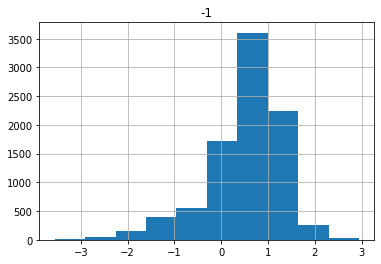

In [18]:
feature_df.hist()

## Reshape Data

In [122]:
params = {
    'loss': 'ce',
    'batch_size': 1,
    'window_size': 20,
    'flatten_input': True
}

train_np, val_np, test_np = zip(*map(pd_to_np_tvt, (feature_df, label_df, target_df)))
obs_shape = (train_np[0].shape[1], params['window_size'], train_np[0].shape[-1])	# Feature observation shape - (Channels, Window, Hours / Window Observations)
shapes = np.asarray(tuple(map(lambda tvt: tuple(map(np.shape, tvt)), (train_np, val_np, test_np))))
assert all(np.array_equal(a[:, 1:], b[:, 1:]) for a, b in pairwise(shapes)), 'feature, label, target shapes must be identical across splits'
assert all(len(np.unique(mat.T[0, :]))==1 for mat in shapes), 'first dimension (N) must be identical length in each split for all (feature, label, and target) tensors'

In [123]:
def __preproc__(data, m_params, t_params, obs_shape, overlap=True):
    x, y, z = temporal_preproc_3d(data, window_size=m_params['window_size'], apply_idx=[0]) if (overlap) else stride_preproc_3d(data, window_size=m_params['window_size'])
    if (m_params['loss'] in ('bce', 'bcel', 'ce', 'nll')):
        y_new = np.sum(y, axis=(1, 2), keepdims=False)		# Sum label matrices to scalar values
        if (y.shape[1] > 1):
            y_new += y.shape[1]								# Shift to range [0, C-1]
        if (m_params['loss'] in ('bce', 'bcel')):
            y_new = np.expand_dims(y_new, axis=-1)
        y = y_new
    if (t_params['flatten_input']):
        x = x.reshape(x.shape[0], int(obs_shape[0]*obs_shape[1]*obs_shape[2]))
    return (x, y, z)

#@pl.data_loader
def train_dataloader(t_params, flt):
    logging.info('train_dataloader called')
    return batchify(t_params, __preproc__(flt), False)

#@pl.data_loader
def val_dataloader(t_params, flt):
    logging.info('val_dataloader called')
    return batchify(t_params, __preproc__(flt), False)

#@pl.data_loader
def test_dataloader(t_params, flt):
    logging.info('test_dataloader called')
    return batchify(t_params, __preproc__(flt), False)

In [124]:
train_ol_np = __preproc__(train_np, params, params, obs_shape)
val_ol_np = __preproc__(val_np, params, params, obs_shape)
test_ol_np = __preproc__(test_np, params, params, obs_shape)
print(tuple(map(lambda tvt: tuple(map(np.shape, tvt)), (train_np, val_np, test_np)))[0])
print(tuple(map(np.shape, train_ol_np)))
print(np_value_counts(train_ol_np[1])[1] / sum(np_value_counts(train_ol_np[1])[1]))
print(np_value_counts(val_ol_np[1])[1] / sum(np_value_counts(val_ol_np[1])[1]))
print(np_value_counts(test_ol_np[1])[1] / sum(np_value_counts(test_ol_np[1])[1]))

((1359, 4, 1), (1359, 1, 2), (1359, 1, 2))
((1340, 80), (1340,), (1340, 1, 2))
[0.44253731 0.55746269]
[0.49078341 0.50921659]
[0.46543779 0.53456221]


In [125]:
def batchify(params, data, shuffle_batches=False):
	"""
	Return a torch.DataLoader made from a tuple of numpy arrays.

	Args:
		params (dict): model parameters dictionary
		data (tuple): tuple of numpy arrays, features are the first element
		shuffle_batches (bool): whether or not to shuffle the batches

	Returns:
		torch.DataLoader
	"""
	f = torch.tensor(data[0], dtype=torch.float32, requires_grad=True)
	if (params['loss'] in ('bce', 'bcel', 'mae', 'mse')):
		l = torch.tensor(data[1], dtype=torch.float32, requires_grad=False)
	elif (params['loss'] in ('ce', 'nll')):
		l = torch.tensor(data[1], dtype=torch.int64, requires_grad=False).squeeze()
	t = torch.tensor(data[2], dtype=torch.float32, requires_grad=False)
	ds = TensorDataset(f, l, t)
	dl = DataLoader(ds, batch_size=params['batch_size'], shuffle=shuffle_batches)
	return dl

In [126]:
train_dl = batchify({'loss': 'ce', 'batch_size': 256}, train_ol_np)
val_dl = batchify({'loss': 'ce', 'batch_size': 256}, val_ol_np)

## Pyro

In [247]:
from torch.autograd import Variable
import pyro
from pyro.nn import PyroModule, PyroSample
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide.guides import AutoDiagonalNormal, AutoNormal
from pyro.optim import Adam
from pyro.distributions import Normal, Uniform

In [253]:
class Net(torch.nn.Module):
    def __init__(self, block_sizes, out_shape):
        super(Net, self).__init__()
        layers = []
        for i, (in_size, out_size) in enumerate(pairwise(block_sizes)):
            layers.append(('LL_{i}'.format(i=i), torch.nn.Linear(in_size, out_size)))
        self.emb = nn.Sequential(OrderedDict(layers))
        self.out = torch.nn.Linear(block_sizes[-1], out_shape)

    def forward(self, x, y=None):
        out_embedding = self.emb(x)
        out_linear = self.out(out_embedding)
        return out_linear

In [254]:
out_shape = 2
block_sizes = [np.product(train_ol_np[0].shape[1:]), 40, 40]
model = Net(block_sizes, out_shape)
pyro.nn.module.to_pyro_module_(model)

# Now we can attempt to be fully Bayesian:
for m in model.modules():
    for name, value in list(m.named_parameters(recurse=True)):
        setattr(m, name, PyroSample(prior=Normal(0, 1)
                                              .expand(value.shape)
                                              .to_event(value.dim())))
guide = AutoDiagonalNormal(model)

In [255]:
model

PyroNet(
  (emb): PyroSequential(
    (LL_0): PyroLinear(in_features=80, out_features=40, bias=True)
    (LL_1): PyroLinear(in_features=40, out_features=40, bias=True)
  )
  (out): PyroLinear(in_features=40, out_features=2, bias=True)
)

In [251]:
svi = SVI(model, guide, Adam({"lr": 0.03}), loss=Trace_ELBO())

In [252]:
pyro.clear_param_store()
for i in range(1000):
    for j, (x, y, z) in enumerate(train_dl):
        # calculate the loss and take a gradient step
        loss = svi.step(x, y)
    if i % 100 == 0:
        print("[iteration {:04d}] loss: {:.5f}".format(i, loss / len(train_ol_np[0])))

[iteration 0000] loss: 6.13925
[iteration 0100] loss: 0.06479
[iteration 0200] loss: 0.06531
[iteration 0300] loss: 0.07232


KeyboardInterrupt: 

In [180]:
def model(data, pyt_model, block_sizes, out_shape):
    priors = {}
    for i, (in_size, out_size) in enumerate(pairwise(block_sizes)):
        mu = Variable(torch.zeros(out_size, in_size)).type_as(data)
        sigma = Variable(torch.ones(out_size, in_size)).type_as(data)
        bias_mu = Variable(torch.zeros(out_size)).type_as(data)
        bias_sigma = Variable(torch.ones(out_size)).type_as(data)
        priors['{}.weight'.format(i)] = Normal(mu, sigma)
        priors['{}.bias'.format(i)] = Normal(bias_mu, bias_sigma)

    mu = Variable(torch.zeros(out_shape, block_sizes[-1])).type_as(data)
    sigma = Variable(torch.ones(out_shape, block_sizes[-1])).type_as(data)
    bias_mu = Variable(torch.zeros(out_shape)).type_as(data)
    bias_sigma = Variable(torch.ones(out_shape)).type_as(data)
    priors['{}.weight'.format('out')] = Normal(mu, sigma)
    priors['{}.bias'.format('out')] = Normal(bias_mu, bias_sigma) 
    
    # lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module('module', pyt_model, priors)
    # sample a model (which also samples w and b)
    lifted_model = lifted_module()

    with pyro.iarange('map', len(data[0]), subsample=data):
        #x_data = data[:, :-1]
        #y_data = data[:, -1]
        # run the model forward conditioned on inputs
        prediction_mean = pyt_model(data[0]).squeeze()
        pyro.sample('obs', Normal(prediction_mean, Variable(torch.ones(data.size(0))).type_as(data)), obs=data[1].squeeze())
        

def guide(data, pyt_model, block_sizes, out_shape):
    dists = {}
    softplus = nn.Softplus()
    for i, (in_size, out_size) in enumerate(pairwise(block_sizes)):
        w_mu = Variable(torch.randn(out_size, in_size).type_as(data.data), requires_grad=True)
        w_log_sig = Variable(0.1 * torch.ones(out_size, in_size).type_as(data.data), requires_grad=True)
        b_mu = Variable(torch.randn(out_size).type_as(data.data), requires_grad=True)
        b_log_sig = Variable(0.1 * torch.ones(out_size).type_as(data.data), requires_grad=True)

        # register learnable params in the param store
        mw_param = pyro.param('{}.guide_mean_weight'.format(i), w_mu)
        sw_param = softplus(pyro.param('{}.guide_log_sigma_weight'.format(i), w_log_sig))
        mb_param = pyro.param('{}.guide_mean_bias'.format(i), b_mu)
        sb_param = softplus(pyro.param('{}.guide_log_sigma_bias'.format(i), b_log_sig))

        # gaussian guide distributions for w and b
        dists['{}.weight'.format(i)] = Normal(mw_param, sw_param)
        dists['{}.bias'.format(i)] = Normal(mb_param, sb_param)
    
    w_mu = Variable(torch.randn(out_shape, block_sizes[-1]).type_as(data.data), requires_grad=True)
    w_log_sig = Variable(0.1 * torch.randn(out_shape, block_sizes[-1]).type_as(data.data), requires_grad=True)
    b_mu = Variable(torch.randn(out_shape).type_as(data.data), requires_grad=True)
    b_log_sig = Variable(0.1 * torch.ones(out_shape).type_as(data.data), requires_grad=True)

    # register learnable params in the param store
    mw_param = pyro.param('{}.guide_mean_weight'.format('out'), w_mu)
    sw_param = softplus(pyro.param('{}.guide_log_sigma_weight'.format('out'), w_log_sig))
    mb_param = pyro.param('{}.guide_mean_bias'.format('out'), b_mu)
    sb_param = softplus(pyro.param('{}.guide_log_sigma_bias'.format('out'), b_log_sig))

    # gaussian guide distributions for w and b
    dists['{}.weight'.format('out')] = Normal(mw_param, sw_param)
    dists['{}.bias'.format('out')] = Normal(mb_param, sb_param)
    
    # overloading the parameters in the module with random samples from the guide distributions
    lifted_module = pyro.random_module('module', pyt_model, dists)
    # sample a model
    return lifted_module()

In [181]:
out_shape = 2
block_sizes = [np.product(train_ol_np[0].shape[1:]), 200, 200]
mdl = Net(block_sizes, out_shape)
svi = SVI(partial(model, pyt_model=mdl, block_sizes=block_sizes, out_shape=out_shape),
                     partial(guide, pyt_model=mdl, block_sizes=block_sizes, out_shape=out_shape),
                     Adam({'lr': 0.001}),
                     loss=Trace_ELBO())

In [182]:
# instantiate optim and inference objects
for j in range(100):
    epoch_loss = 0.0
    for x, y, z in train_dl:
        epoch_loss += svi.step(x)
    if (j%10==0):
        print(j, "avg loss {}".format(epoch_loss/float(1340)))
        
# for j in range(3000):
#     epoch_loss = 0.0
#     #perm = torch.randperm(N)
#     # shuffle data
#     #data = data[perm]
#     # get indices of each batch
#     all_batches = get_batch_indices(N, 64)
#     for ix, batch_start in enumerate(all_batches[:-1]):
#         batch_end = all_batches[ix + 1]
#         batch_data = data[batch_start: batch_end]        
#         epoch_loss += svi.step(batch_data)
#     if j % 100 == 0:
#         print(j, "avg loss {}".format(epoch_loss/float(N)))

RuntimeError: The size of tensor a (2) must match the size of tensor b (256) at non-singleton dimension 0
           Trace Shapes:            
            Param Sites:            
module$$$emb.LL_0.weight     200  80
  module$$$emb.LL_0.bias         200
module$$$emb.LL_1.weight     200 200
  module$$$emb.LL_1.bias         200
           Sample Sites:            
module$$$out.weight dist   2 200   |
                   value   2 200   |
  module$$$out.bias dist       2   |
                   value       2   |
                map dist           |
                   value 256  80   |

In [48]:
preds = []
for i in range(100):
    sampled_model = guide(X_test)
    pred = sampled_model(X_test).data.numpy().flatten()
    preds.append(pred)

preds = np.array(preds)
mean = np.mean(preds, axis=0)
std = np.std(preds, axis=0) / 10
y_test = Y_test.data.numpy()
x = np.arange(len(y_test))

plt.figure()
plt.plot(original)
plt.plot(predicted, linestyle = '--')
plt.show()

plt.figure()
plt.plot(x, y_test)
plt.plot(x, mean, linestyle = '--')
plt.fill_between(x, mean-std, mean+std, alpha = 0.3, color = 'orange')
plt.show()

NameError: name 'X_test' is not defined

In [19]:
from model.pl_tcn import TCNModel

In [116]:
m_params = {
	'pad_type': 'same',    
	'num_blocks': 1,
	#'block_channels': [[80, 80, 80]],
	'block_channels': [[70, 70, 70]],
	#'block_channels': [[80, 70, 60]],
	#'block_channels': [[70, 60, 50]],
	'block_act': 'relu',
	'out_act': 'relu',
	'block_init': 'normal',
	'out_init': 'normal',
	'kernel_sizes': [7],
	'dilation_index': 'global',
	'global_dropout': 0,
	'no_dropout': [0],
	'out_shape': len(chosen_l.columns)*len(chosen_l.index.levels[1]) # directions * slots per direction
}
t_params = {
	'window_size': 20,
	'epochs': 200,#500,
	'batch_size': 64*2,
	'loss': 'ce',
	'flatten_input': True,
	'opt': {
		'name': 'adam',
		'kwargs': {
			'lr': .001
		}
	},
	'sch': {
#		'name': 'rpl',
#		'kwargs': {
#			'mode': 'min',
#			'factor': 0.1,
#			'patience': 10,
#			'threshold': 0.0001,
#			'threshold_mode': 'rel',
#			'cooldown': 0,
#			'min_lr': 0
#		}
	}
}

In [355]:
mdl = TCNModel(m_params, t_params, (feature_df, label_df, target_df))

In [356]:
mdl

TCNModel(
  (loss): CrossEntropyLoss()
  (clf): OutputLinear(
    (emb): TemporalConvNet(
      (convnet): Sequential(
        (RB_0): ResidualBlock(
          (net): Sequential(
            (TL_0_0): TemporalLayer1d(
              (layer): Sequential(
                (0): Conv1d(4, 60, kernel_size=(7,), stride=(1,), padding=(3,))
                (1): ReLU()
                (2): Dropout(p=0, inplace=False)
              )
            )
            (TL_0_1): TemporalLayer1d(
              (layer): Sequential(
                (0): Conv1d(60, 60, kernel_size=(7,), stride=(1,), padding=(6,), dilation=(2,))
                (1): ReLU()
                (2): Dropout(p=0, inplace=False)
              )
            )
            (TL_0_2): TemporalLayer1d(
              (layer): Sequential(
                (0): Conv1d(60, 60, kernel_size=(7,), stride=(1,), padding=(12,), dilation=(4,))
                (1): ReLU()
                (2): Dropout(p=0, inplace=False)
              )
            )
     

In [357]:
escb = EarlyStopping(monitor='val_loss', min_delta=0.00, patience=30, verbose=False, mode='min')
trainer = pl.Trainer(max_nb_epochs=t_params['epochs'], early_stop_callback=escb, auto_lr_find=False, gpus=1, amp_level='O1', use_amp=True)

In [358]:
trainer.fit(mdl)

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


1

In [211]:
for i in range(5):
    mdl = TCNModel(m_params, t_params, (feature_df, label_df, target_df))
    trainer = pl.Trainer(max_nb_epochs=t_params['epochs'], gpus=1, amp_level='O1', use_amp=True)
    trainer.fit(mdl)

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic



Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


KeyboardInterrupt: 

## Debug Data (Runtime Transforms)

### Split into Train/Val/Test and Convert to Numpy Tensor

In [129]:
train_np, val_np, test_np = zip(*map(pd_to_np_tvt, (feature_df, label_df, target_df)))
shapes = np.asarray(tuple(map(lambda tvt: tuple(map(np.shape, tvt)), (train_np, val_np, test_np))))
assert all(np.array_equal(a[:, 1:], b[:, 1:]) for a, b in pairwise(shapes)), 'feature, label, target shapes must be identical across splits'
assert all(len(np.unique(mat.T[0, :]))==1 for mat in shapes), 'first dimension (N) must be identical length in each split for all (feature, label, and target) tensors'

AssertionError: first dimension (N) must be identical length in each split for all (feature, label, and target) tensors

### Runtime Preproc

In [609]:
params = {
    'loss': 'ce',
    'batch_size': 1,
    'window_size': 20,
}

In [610]:
def __preproc__(data, m_params, overlap=True):
    x, y, z = temporal_preproc_3d(data, window_size=m_params['window_size'], apply_idx=[0]) if (overlap) else stride_preproc_3d(data, window_size=m_params['window_size'])
    if (m_params['loss'] in ('bce', 'bcel', 'ce', 'nll')):
        y_new = np.sum(y, axis=(1, 2), keepdims=False)		# Sum label matrices to scalar values
        if (y.shape[1] > 1):
            y_new += y.shape[1]								# Shift to range [0, C-1]
        if (m_params['loss'] in ('bce', 'bcel')):
            y_new = np.expand_dims(y_new, axis=-1)
        y = y_new
    return (x, y, z)

#@pl.data_loader
def train_dataloader(t_params, flt):
    logging.info('train_dataloader called')
    return batchify(t_params, __preproc__(flt), False)

#@pl.data_loader
def val_dataloader(t_params, flt):
    logging.info('val_dataloader called')
    return batchify(t_params, __preproc__(flt), False)

#@pl.data_loader
def test_dataloader(t_params, flt):
    logging.info('test_dataloader called')
    return batchify(t_params, __preproc__(flt), False)

### Overlapping Episodes:

In [611]:
train_ol_np = __preproc__(train_np, params)
val_ol_np = __preproc__(val_np, params)
test_ol_np = __preproc__(test_np, params)
print(tuple(map(lambda tvt: tuple(map(np.shape, tvt)), (train_np, val_np, test_np)))[0])
print(tuple(map(np.shape, train_ol_np)))
print(np_value_counts(train_ol_np[1]))

((1359, 3, 8), (1359, 1, 2), (1359, 1, 2))
((1340, 3, 160), (1340,), (1340, 1, 2))
(array([0., 1.]), array([593, 747]))


### Non-Overlapping Episodes:

In [612]:
train_nol_np = __preproc__(train_np, params, False)
val_nol_np = __preproc__(val_np, params, False)
test_nol_np = __preproc__(test_np, params, False)
print(tuple(map(lambda tvt: tuple(map(np.shape, tvt)), (train_np, val_np, test_np)))[0])
print(tuple(map(np.shape, train_nol_np)))

((1359, 3, 8), (1359, 1, 2), (1359, 1, 2))
((67, 3, 20, 8), (67, 2), (67, 1, 20, 2))


In [613]:
def batchify(params, data, shuffle_batches=False):
	"""
	Return a torch.DataLoader made from a tuple of numpy arrays.

	Args:
		params (dict): model parameters dictionary
		data (tuple): tuple of numpy arrays, features are the first element
		shuffle_batches (bool): whether or not to shuffle the batches

	Returns:
		torch.DataLoader
	"""
	f = torch.tensor(data[0], dtype=torch.float32, requires_grad=True)
	if (params['loss'] in ('bce', 'bcel', 'mae', 'mse')):
		l = [torch.tensor(d, dtype=torch.float32, requires_grad=False) for d in data[1:]]
	elif (params['loss'] in ('ce', 'nll')):
		l = [torch.tensor(d, dtype=torch.int64, requires_grad=False).squeeze() for d in data[1:]]
	ds = TensorDataset(f, *l)
	dl = DataLoader(ds, batch_size=params['batch_size'], shuffle=shuffle_batches)
	return ds

## Sklearn Tests

In [614]:
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier, ElasticNet
from sklearn.tree import DecisionTreeClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, StackingClassifier

In [615]:
x_train, y_train, z_train = train_ol_np
x_val, y_val, z_val = val_ol_np
x_test, y_test, z_test = test_ol_np

In [616]:
def np_collapse_last_two_dim(arr):
    return arr.reshape(arr.shape[0], arr.shape[1]*arr.shape[2])

In [617]:
x_train.reshape(1340, 800)

ValueError: cannot reshape array of size 643200 into shape (1340,800)

In [618]:
x_train_new = np_collapse_last_two_dim(x_train)
x_val_new = np_collapse_last_two_dim(x_val)
x_test_new = np_collapse_last_two_dim(x_test)

In [619]:
# Logistic Regression
clf = LogisticRegression(C=10**-2, l1_ratio=.9, penalty='elasticnet', random_state=0, solver='saga').fit(x_train_new, y_train)
sc = clf.score(x_val_new, y_val)
print('base :', y_val.mean())
print('score:', sc)
print('diff : {:%}'.format((sc-y_val.mean())))

base : 0.5092165898617511
score: 0.5092165898617511
diff : 0.000000%


In [620]:
# SGDClassifier
clf = SGDClassifier(alpha=10**-2, l1_ratio=.8, loss='log', penalty='elasticnet', random_state=0).fit(x_train_new, y_train)
sc = clf.score(x_val_new, y_val)
print('base :', y_val.mean())
print('score:', sc)
print('diff : {:%}'.format((sc-y_val.mean())))

base : 0.5092165898617511
score: 0.5069124423963134
diff : -0.230415%


In [621]:
# SGDClassifier
clf = SGDClassifier(alpha=10**-5, l1_ratio=.1, loss='modified_huber', max_iter=1000, penalty='elasticnet', random_state=0).fit(x_train_new, y_train)
sc = clf.score(x_val_new, y_val)
print('base :', y_val.mean())
print('score:', sc)
print('diff : {:%}'.format((sc-y_val.mean())))

base : 0.5092165898617511
score: 0.5230414746543779
diff : 1.382488%


In [622]:
# RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, criterion='gini', bootstrap=True, max_depth=4, min_impurity_decrease=0, random_state=0).fit(x_train_new, y_train)
sc = clf.score(x_val_new, y_val)
print('base :', y_val.mean())
print('score:', sc)
print('diff : {:%}'.format((sc-y_val.mean())))

base : 0.5092165898617511
score: 0.5069124423963134
diff : -0.230415%


In [635]:
# RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, criterion='entropy', bootstrap=True, max_depth=None,
                             min_impurity_decrease=0, random_state=0).fit(x_train_new, y_train)
sc = clf.score(x_val_new, y_val)
print('base :', y_val.mean())
print('score:', sc)
print('diff : {:%}'.format((sc-y_val.mean())))

base : 0.5092165898617511
score: 0.4769585253456221
diff : -3.225806%


In [624]:
# RandomForestClassifier
clf = RandomForestClassifier(n_estimators=7, class_weight='balanced_subsample', criterion='entropy',
                             bootstrap=True, max_depth=3, min_impurity_decrease=0, random_state=0).fit(x_train_new, y_train)
sc = clf.score(x_val_new, y_val)
print('base :', y_val.mean())
print('score:', sc)
print('diff : {:%}'.format((sc-y_val.mean())))

base : 0.5092165898617511
score: 0.4930875576036866
diff : -1.612903%


In [625]:
# RandomForestClassifier
clf = RandomForestClassifier(n_estimators=1000, class_weight='balanced_subsample', criterion='entropy',
                             bootstrap=True, max_depth=4, min_impurity_decrease=0, random_state=0).fit(x_train_new, y_train)
sc = clf.score(x_val_new, y_val)
print('base :', y_val.mean())
print('score:', sc)
print('diff : {:%}'.format((sc-y_val.mean())))

base : 0.5092165898617511
score: 0.49078341013824883
diff : -1.843318%


In [626]:
# GradientBoostingClassifier
clf = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=100, subsample=1.0,
                                 criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1,
                                 min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, random_state=0).fit(x_train_new, y_train)
sc = clf.score(x_val_new, y_val)
print('base :', y_val.mean())
print('score:', sc)
print('diff : {:%}'.format((sc-y_val.mean())))

base : 0.5092165898617511
score: 0.4861751152073733
diff : -2.304147%


In [627]:
# GradientBoostingClassifier
clf = GradientBoostingClassifier(loss='exponential', learning_rate=0.1, n_estimators=100, subsample=1.0,
                                 criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1,
                                 min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, random_state=0).fit(x_train_new, y_train)
sc = clf.score(x_val_new, y_val)
print('base :', y_val.mean())
print('score:', sc)
print('diff : {:%}'.format((sc-y_val.mean())))

base : 0.5092165898617511
score: 0.4861751152073733
diff : -2.304147%


In [628]:
# HistGradientBoostingClassifier
clf = HistGradientBoostingClassifier(loss='auto', learning_rate=0.1, max_iter=100, max_leaf_nodes=31,
                                     max_depth=4, min_samples_leaf=20, l2_regularization=0.0, max_bins=255, random_state=0).fit(x_train_new, y_train)
sc = clf.score(x_val_new, y_val)
print('base :', y_val.mean())
print('score:', sc)
print('diff : {:%}'.format((sc-y_val.mean())))

base : 0.5092165898617511
score: 0.46543778801843316
diff : -4.377880%


In [629]:
# RF Alt 1
clf1 = DecisionTreeClassifier(criterion='entropy', max_depth=3, max_features='auto', class_weight='balanced')
clf = BaggingClassifier(base_estimator=clf1, bootstrap=True, bootstrap_features=False, n_estimators=100, random_state=0).fit(x_train_new, y_train)
sc = clf.score(x_val_new, y_val)
print('base :', y_val.mean())
print('score:', sc)
print('diff : {:%}'.format((sc-y_val.mean())))

base : 0.5092165898617511
score: 0.532258064516129
diff : 2.304147%


In [630]:
# RF Alt 2
clf = RandomForestClassifier(n_estimators=1, class_weight='balanced_subsample', criterion='entropy',
                             bootstrap=False, max_depth=3, min_impurity_decrease=0, random_state=0)
clf = BaggingClassifier(base_estimator=clf1, bootstrap=True, bootstrap_features=False, n_estimators=1000, random_state=0).fit(x_train_new, y_train)
sc = clf.score(x_val_new, y_val)
print('base :', y_val.mean())
print('score:', sc)
print('diff : {:%}'.format((sc-y_val.mean())))

base : 0.5092165898617511
score: 0.5069124423963134
diff : -0.230415%


In [598]:
random_states = range(10)
results = np.zeros(len(random_states))
y_mean = y_val.mean()
for r in random_states:
        # RandomForestClassifier
    clf = RandomForestClassifier(n_estimators=100, class_weight=None, criterion='entropy',
                                 bootstrap=True, max_depth=None, min_impurity_decrease=0, random_state=r).fit(x_train_new, y_train)
    sc = clf.score(x_val_new, y_val)
    diff = sc-y_mean
    results[r] = diff*100
    #print('base :', y_val.mean())
    #print('score:', sc)
    #print('diff : {:%}'.format((sc-y_val.mean())))
print(results)
print(results.mean())

[ 2.76497696 -2.99539171 -3.4562212   2.07373272  1.38248848 -1.61290323
 -0.92165899  0.46082949 -1.84331797 -3.68663594]
-0.783410138248844


In [67]:
# Few Shot Tests
# XXX - Need to update for code changes
tr_split = .75
w = params['window_size']
tr, ts = int(tr_split*w), (1-tr_split)*w
print(tr, ts)

scs = []
for x, y, z in zip(*train_nol_np):
    x, y = x.T, y
    print(x.shape)
    print(x[0:tr].shape)
    print(x[tr:].shape)
    break
    clf = LogisticRegression(C=10**-2, l1_ratio=.9, penalty='elasticnet', random_state=0, solver='saga').fit(x[0:tr], y[0:tr].squeeze())
    #clf = LinearRegression().fit(x[0:tr], y[0:tr].squeeze())
    #yh = clf.predict(x[tr:])
    #|yp = clf.predict_proba(x[tr:])
    sc = clf.score(x[tr:], y[tr:].squeeze())
    scs.append(sc)
    #print(sc)
    #print(x)
    #print(y.squeeze())
    #print(z.T)

15 5.0
(160, 5)
(15, 5)
(145, 5)


In [68]:
(np.array(scs).mean()-train_nol[1].squeeze().mean())*100

/home/kev/crunch/model/nb-model_xg-model-data-fi.ipynb:1: RuntimeWarning: Mean of empty slice.
  {
/home/kev/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


NameError: name 'train_nol' is not defined